# GLM demo with rebound neurons

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

DT = .001  # timestep (s)
T_H = .1  # filter length for all filters (stim, post-spike, other neurons) (s)

## Set up stim filters

In [2]:
t_h = np.arange(0, T_H, DT)  # time vector for filters
n_t_h = len(t_h)  # num time steps in filter time vector

# make 2-D array of stim filters
h_stim = np.zeros((2, n_t_h))  # each row is stim filter for one neuron
h_stim[0, :] = np.exp(-t_h/.04)*np.sin(2*np.pi*t_h/.08) # stim filter for neuron 0
h_stim[0, :] = h_stim[0, :] / np.linalg.norm(h_stim[0, :])  # normalize
h_stim[1, :] = np.exp(-t_h/.08)*np.sin(2*np.pi*t_h/.08) # stim filter for neuron 1
h_stim[1, :] = h_stim[1, :] / np.linalg.norm(h_stim[1, :])  # normalize

## Plot

Text(0, 0.5, 'Filter weight')

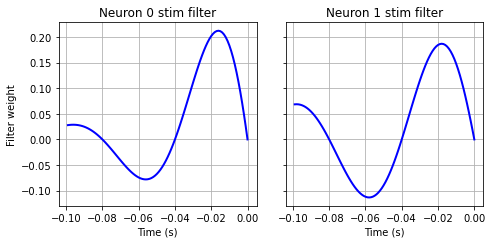

In [3]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True, tight_layout=True)
axs[0].plot(-t_h, h_stim[0, :], lw=2, c='b')
axs[0].set_title('Neuron 0 stim filter')
axs[1].plot(-t_h, h_stim[1, :], lw=2, c='b')
axs[1].set_title('Neuron 1 stim filter')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.grid()
axs[0].set_ylabel('Filter weight')

## Setup post-spike and neuron-to-neuron filters

In [4]:
# make 3-D array of neuron-to-neuron filters for 2 neurons (like a recurrent weight matrix except each weight is a filter)
# h_nrn[0, 1, :] is filter TO neuron 0 from neuron 1
# h_nrn[0, 0] is neuron 0's post-spike filter
h_nrn = np.zeros((2, 2, n_t_h))

# neuron 0 post-spike filter
h_nrn[0, 0, :] = -np.exp(-t_h/.001)*t_h/.01
# neuron 1 post-spike filter
h_nrn[1, 1, :] = -np.exp(-t_h/.001)*t_h/.01

# filter TO neuron 0 FROM neuron 1
w_01 = 1  # scale factor/weight for filter to neuron 0 from neuron 1
h_nrn[0, 1, :] = -w_01*np.exp(-t_h/.02)/.05  # neuron 0 is inhibited by neuron 1

# filter TO neuron 1 FROM neuron 0
w_10 = 500  # scale factor/weight for filter to neuron 1 from neuron 0
h_nrn[1, 0, :] = w_10*np.exp(-t_h/.02)/.05  # neuron 1 is excited by neuron 0

## Plot

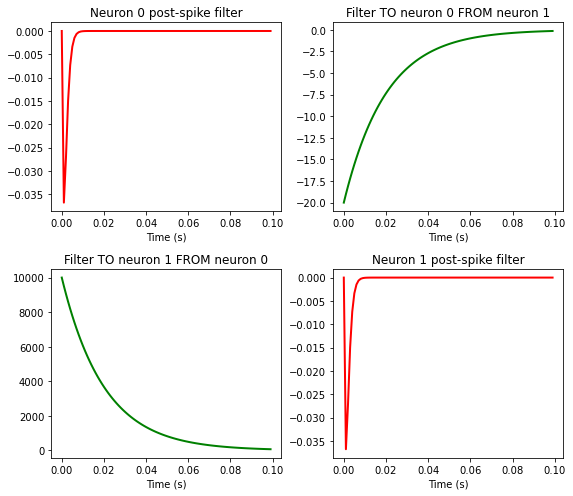

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7), tight_layout=True)
for i_to in range(2):
    for i_from in range(2):
        ax = axs[i_to, i_from]
        if i_to == i_from:
            ax.plot(t_h, h_nrn[i_to, i_from, :], lw=2, c='r')
            ax.set_title(f'Neuron {i_to} post-spike filter')
        else:
            ax.plot(t_h, h_nrn[i_to, i_from, :], lw=2, c='g')
            ax.set_title(f'Filter TO neuron {i_to} FROM neuron {i_from}')
            
        ax.set_xlabel('Time (s)')

## Set up nonlinearities

In [6]:
alpha = .1/DT  # scale factor
beta = 1/.02  # slope
x_0 = .2  # offset

def nonlin(x):
    return alpha/(1 + np.exp(-beta*(x - x_0)))

## Plot

Text(0, 0.5, 'Firing rate (Hz)')

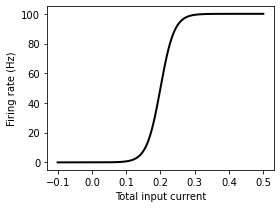

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
x_demo = np.linspace(-.1, .5, 1000)
ax.plot(x_demo, nonlin(x_demo), c='k', lw=2)
ax.set_xlabel('Total input current')
ax.set_ylabel('Firing rate (Hz)')

# Set up simulation

In [8]:
t_smln = np.arange(0, .8, DT)  # time vector for 800 ms simulation
n_t_smln = len(t_smln)  # num time steps in simulation

# stimulus input current
stim_level = 1500
stim = np.zeros((len(t_smln), 2))  # each col is stimulus received by one neuron

t_mask_stim = (.2 < t_smln) & (t_smln < .5)  # stim on from .2 s to .5 s
stim[t_mask_stim, 0] = -1*stim_level # stim to neuron 0
stim[t_mask_stim, 1] = -1*stim_level # stim to neuron 1

## Run simulation

In [9]:
curs_stim = np.nan * np.zeros((len(t_smln), 2))  # space to store filtered stimulus (# time steps x # neurons)
curs_post_spike = np.nan * np.zeros((len(t_smln), 2))  # space to store filtered own past spikes (# time steps x # neurons)
curs_other_nrns = np.nan * np.zeros((len(t_smln), 2))  # space to store total filtered past spikes from other neurons (# time steps x # neurons)
curs_total = np.nan * np.zeros((len(t_smln), 2))  # space to store total input currents (# time steps x # neurons)
frs = np.nan * np.zeros((len(t_smln), 2))  # space to store firing rates (# time steps x # neurons)
spks = np.zeros((len(t_smln), 2))  # space to store spikes (all elements will be one or zero) (# time steps x # neurons)

# main simulation loop
np.random.seed(0)  # set random seed (since simulation is probabilistic)
for t_step in range(n_t_h, n_t_smln):  # start one filter-length into smln and run until end
    
    # loop over neurons
    for nrn_idx in range(2):
        
        # get current from filtered stimulus
        cur_stim = DT * stim[t_step-n_t_h:t_step, nrn_idx] @ h_stim[nrn_idx, :][::-1]  # @ means dot product, [::-1] reverses a 1-D array (since we flip filters for convolution)
        
        # get current from filtered past spikes in this and other neurons
        cur_post_spike = 0  # this neuron's past spikes
        cur_other_nrns = 0  # other neurons' past spikes
        
        for upstream_nrn_idx in range(2):
            
            if upstream_nrn_idx == nrn_idx:  # own past spikes
                cur_post_spike = cur_post_spike + DT * spks[t_step-n_t_h:t_step, upstream_nrn_idx] @ h_nrn[nrn_idx, upstream_nrn_idx, :][::-1]
                
            elif upstream_nrn_idx != nrn_idx:  # other neuron's past spikes
                cur_other_nrns = cur_other_nrns + DT * spks[t_step-n_t_h:t_step, upstream_nrn_idx] @ h_nrn[nrn_idx, upstream_nrn_idx, :][::-1]
        
        # compute total input current
        cur_total = cur_stim + cur_post_spike + cur_other_nrns
        
        # store stuff
        curs_stim[t_step, nrn_idx] = cur_stim
        curs_post_spike[t_step, nrn_idx] = cur_post_spike
        curs_other_nrns[t_step, nrn_idx] = cur_other_nrns
        curs_total[t_step, nrn_idx] = cur_total
        
        # convert total input current to firing rate
        fr = nonlin(cur_total)
        frs[t_step, nrn_idx] = fr  # store firing rate
        
        # sample spike/non-spike
        spk = float(np.random.rand() < fr*DT)  # probability of spiking is firing rate x DT (spike is 1 or 0 but we convert to float 1.0 or 0.0)
        
        spks[t_step, nrn_idx] = spk  # store spike/non-spike

## Plot

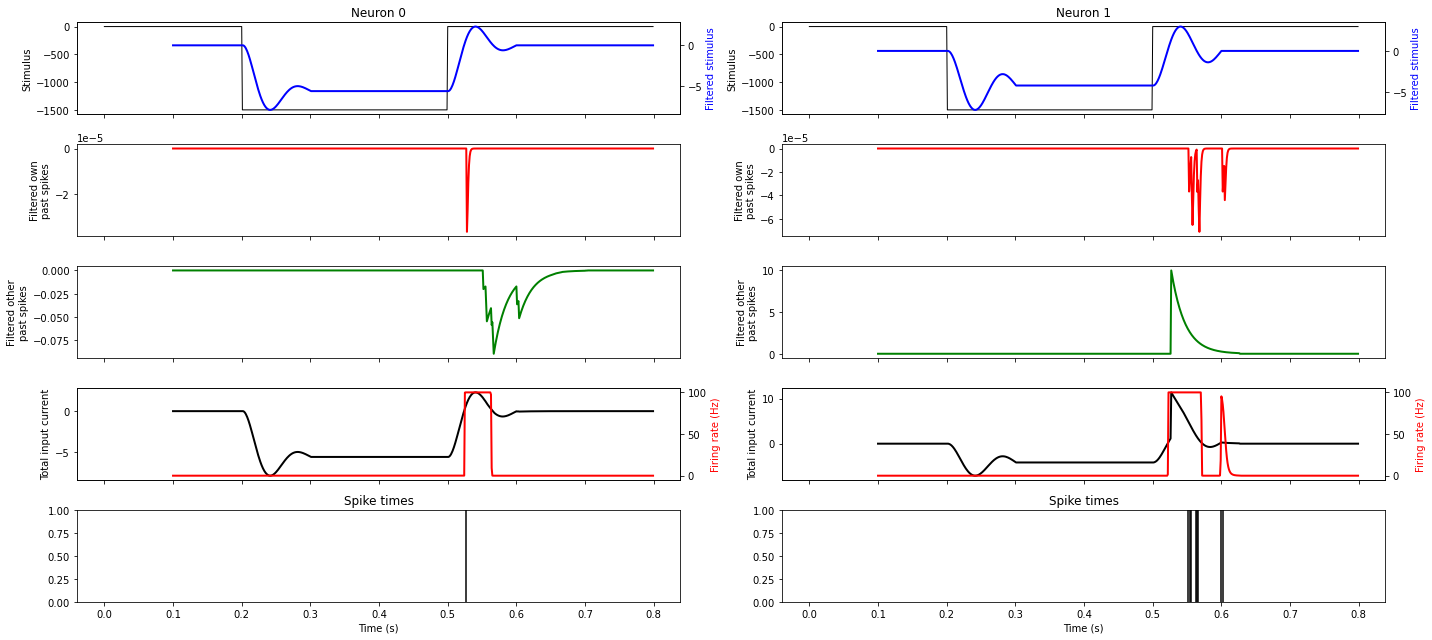

In [10]:
fig, axs_all = plt.subplots(5, 2, figsize=(20, 9), sharex=True, tight_layout=True)
for nrn_idx in range(2):
    axs = axs_all[:, nrn_idx]
    axs[0].plot(t_smln, stim[:, nrn_idx], c='k', lw=1)
    axs[0].set_ylabel('Stimulus')
    axs[0].set_title(f'Neuron {nrn_idx}')
    ax0_twin = axs[0].twinx()
    ax0_twin.plot(t_smln, curs_stim[:, nrn_idx], c='b', lw=2)
    ax0_twin.set_ylabel('Filtered stimulus', color='b')
    
    axs[1].plot(t_smln, curs_post_spike[:, nrn_idx], c='r', lw=2)
    axs[1].set_ylabel('Filtered own\npast spikes')
    
    axs[2].plot(t_smln, curs_other_nrns[:, nrn_idx], c='g', lw=2)
    axs[2].set_ylabel('Filtered other\npast spikes')
    
    axs[3].plot(t_smln, curs_total[:, nrn_idx], c='k', lw=2)
    axs[3].set_ylabel('Total input current')
    ax3_twin = axs[3].twinx()
    ax3_twin.plot(t_smln, frs[:, nrn_idx], c='r', lw=2)
    ax3_twin.set_ylabel('Firing rate (Hz)', color='r')
    
    # get all spike times from spike array
    t_spks = DT*spks[:, nrn_idx].nonzero()[0]
    # plot as vertical lines
    for t_spk in t_spks:
        axs[4].axvline(t_spk, c='k')
    axs[4].set_title('Spike times')
    axs[4].set_xlabel('Time (s)')